# This notebook implements Wasserstein GAN.


In [ ]:
!pip install -r requirements.txt

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as Dataset
import torchvision.transforms as transforms
import os
import numpy as np

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
manualSeed = np.random.randint(1, 10000) # fix seed
print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)

if not os.path.isdir('visualization'):
   os.mkdir('visualization')

Random Seed:  5339


In [11]:
class Config:
    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

conf = Config(im_shape = 64,
            latent_size = 100,
            in_channels=3,
            out_channels = 32,
            kernel_size = 4,
            n_layers = 5,
            batch_size = 16,
            epochs = 2,
            num_workers=2,
            device='cuda')

In [4]:
# Get dataset from image folder
dataset = Dataset.ImageFolder(root="data",
                        transform=transforms.Compose([
                            transforms.Resize(conf.im_shape),
                            transforms.CenterCrop(conf.im_shape),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))
# loader that handle loading stuff
loader = torch.utils.data.DataLoader(dataset, shuffle=True,#, pin_memory=True,
            batch_size=conf.batch_size, 
            drop_last=True,
            num_workers=conf.num_workers)

In [5]:
class EncoderBlock(nn.Module):
    '''
    Typical CNN network that reduces spacial dimension and increase channels at each step.
    '''
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()

        
        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1, bias=False),
                                nn.BatchNorm2d(out_channels),
                                nn.LeakyReLU(0.3))
        
    def forward(self,x):
        return(self.block(x))

class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        in_channels = config.in_channels
        out_channels = config.out_channels
        kernel_size = config.kernel_size
        n_layers = config.n_layers
        
        self.input = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
                                nn.BatchNorm2d(out_channels),
                                nn.LeakyReLU(0.3))
        self.encode = nn.Sequential(*[EncoderBlock(out_channels*2**i, out_channels*2**(i+1), kernel_size) 
                                    for i in range(0,n_layers-1)])
        self.out = nn.Conv2d(out_channels*(2**(n_layers-1)), 1, 4, 1, 0, bias=False)

    def forward(self,x, y = None):
        x = self.input(x)
        x = self.encode(x)
        x = self.out(x)
        # output a single number for discriminator
        output = x.mean(0)

        return x, output.view(1)


discriminator = Discriminator(conf).to(conf.device)
summary(discriminator,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         LeakyReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         LeakyReLU-6           [-1, 64, 32, 32]               0
      EncoderBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        LeakyReLU-10          [-1, 128, 16, 16]               0
     EncoderBlock-11          [-1, 128, 16, 16]               0
           Conv2d-12            [-1, 256, 8, 8]         294,912
      BatchNorm2d-13            [-1, 256, 8, 8]             512
        LeakyReLU-14            [-1, 25

In [6]:
class DecoderBlock(nn.Module):
    '''
    Reverse of Encoder
    '''
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.block = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU())

        
    def forward(self,x):
        return(self.block(x))
        
class Generator(nn.Module):
    def __init__(self, config):
        super().__init__()
        in_channels = config.in_channels
        out_channels = config.out_channels
        kernel_size = config.kernel_size
        n_layers = config.n_layers
        latent_size = config.latent_size

        self.input = nn.Sequential(nn.ConvTranspose2d(latent_size, out_channels*(2**(n_layers-1)), 4, stride=1, bias=False),
                                nn.BatchNorm2d(out_channels*(2**(n_layers-1))),
                                nn.ReLU())
                    
        self.decode = nn.Sequential(*[DecoderBlock(out_channels*2**(i+1), out_channels*2**i, kernel_size) 
                                    for i in range(n_layers-2,-1,-1)])
        
        self.out = nn.Sequential(nn.Conv2d(out_channels, in_channels, 1, 
                                stride=1, padding=0, bias=False))

        
        self.out_channels = out_channels
        self.n_layers = n_layers
        self.im_shape = config.im_shape

    def forward(self,x):
        x = self.input(x)
        
        x = self.decode(x)
        x = torch.tanh(self.out(x))
        
        return x


generator = Generator(conf).to(conf.device)
summary(generator,(100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
      DecoderBlock-7            [-1, 256, 8, 8]               0
   ConvTranspose2d-8          [-1, 128, 16, 16]         524,288
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
     DecoderBlock-11          [-1, 128, 16, 16]               0
  ConvTranspose2d-12           [-1, 64, 32, 32]         131,072
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [7]:
def show_progress(x, it):
    '''
    Display and save visualization
    '''
    discriminator.eval()
    with torch.no_grad():
        num_vis = min(conf.batch_size, 8)
        x = x[0:num_vis]
        x = x.cpu().numpy()
        
        plt.figure(figsize=(num_vis*3, 7))
        for i, obj_plot in enumerate(x):
            
            obj_plot = np.moveaxis(obj_plot, 0, -1)
            plt.subplot(1, num_vis, i+1)
            plt.imshow(obj_plot*0.5 +0.5)

    plt.savefig('visualization/'+ str(it)+'.jpg', format='jpg', bbox_inches='tight')
    plt.show()
    discriminator.train()

In [16]:
device = conf.device
netD = Discriminator(conf).to(device)
netG = Generator(conf).to(device)


optimizerG = torch.optim.RMSprop(netG.parameters(), lr=0.00005)
optimizerD = torch.optim.RMSprop(netD.parameters(), lr=0.00005)

fixed_noise = torch.randn(conf.batch_size, 100, 1, 1).to(device)

loss_D = []
loss_G = []
loss_D_smooth = 0
loss_G_smooth = 0
gen_iterations = 0
pbar = tqdm(total=len(loader))

  1%|          | 100/12662 [00:12<25:27,  8.23it/s]


  0%|          | 0/12662 [00:01<?, ?it/s]
epoch 0 | 0 | netD -0.12599 | netG 0.06086 | D_real -0.65772 | D_fake 0.60217:   1%|          | 100/12662 [00:04<05:38, 37.08it/s]

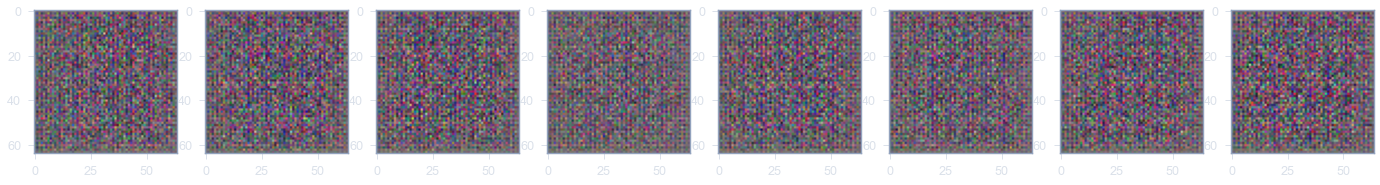

epoch 0 | 500 | netD -0.99128 | netG 0.48162 | D_real -0.59888 | D_fake 0.65740:  24%|██▍       | 3075/12662 [01:40<04:08, 38.56it/s]

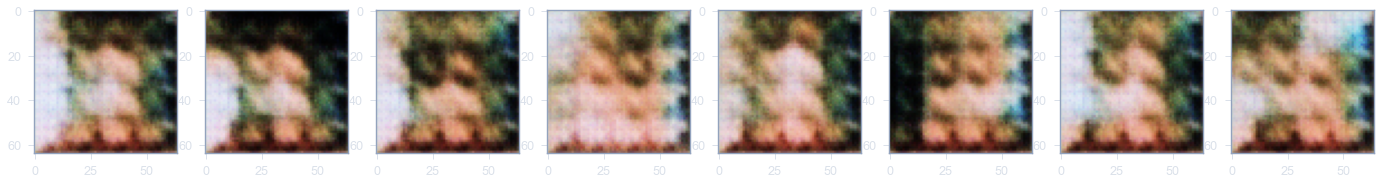

epoch 0 | 1000 | netD -0.82034 | netG 0.45620 | D_real -0.64424 | D_fake 0.42785:  45%|████▍     | 5670/12662 [03:00<03:02, 38.40it/s]

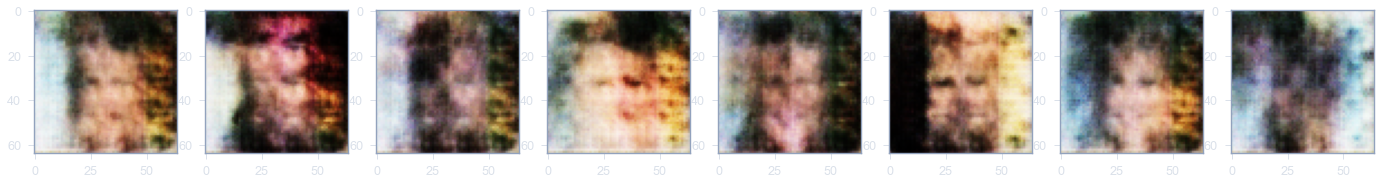

epoch 0 | 1500 | netD -0.69716 | netG 0.36832 | D_real -0.51853 | D_fake 0.51267:  65%|██████▌   | 8265/12662 [04:21<01:54, 38.32it/s]

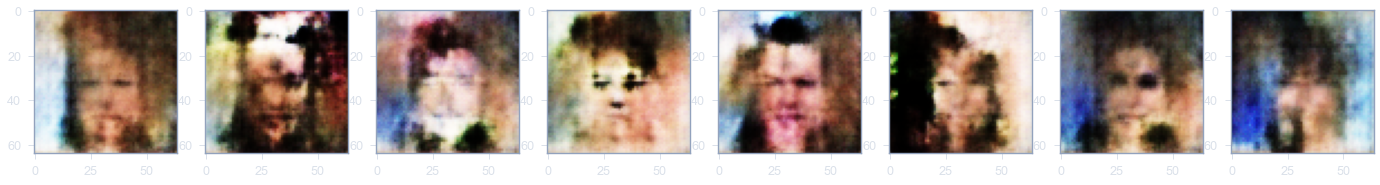

epoch 0 | 2000 | netD -0.66723 | netG 0.38841 | D_real -0.49107 | D_fake 0.42141:  86%|████████▌ | 10860/12662 [05:42<00:47, 38.33it/s]

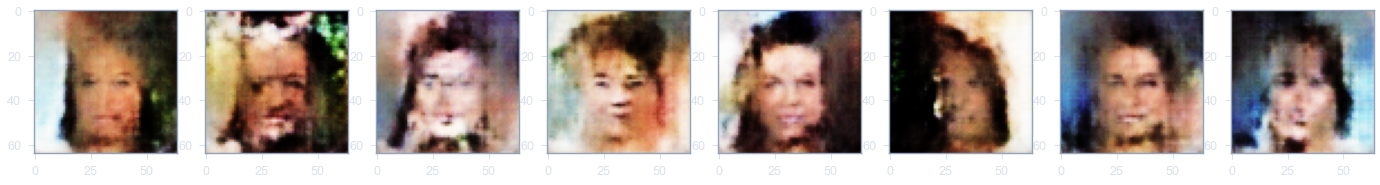

epoch 0 | 2361 | netD -0.60793 | netG 0.36756 | D_real -0.45584 | D_fake 0.24429: 100%|██████████| 12662/12662 [06:39<00:00, 31.71it/s]
epoch 1 | 2500 | netD -0.60908 | netG 0.34537 | D_real -0.39822 | D_fake 0.48549:   6%|▌         | 790/12662 [00:25<05:08, 38.43it/s]

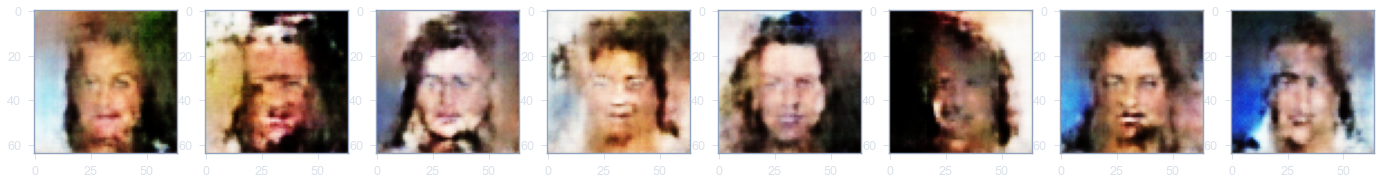

epoch 1 | 3000 | netD -0.58726 | netG 0.31400 | D_real -0.42511 | D_fake 0.47134:  27%|██▋       | 3385/12662 [01:46<04:04, 37.96it/s]

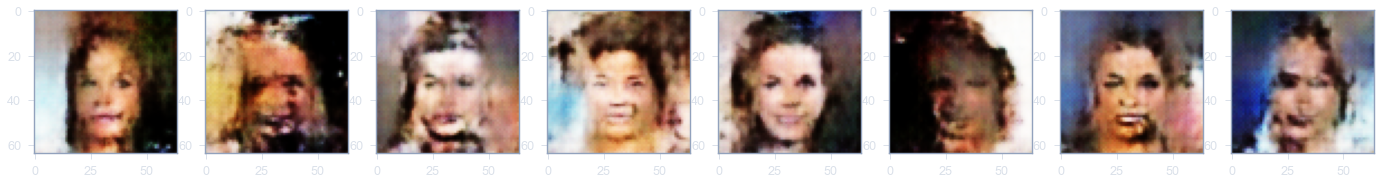

epoch 1 | 3500 | netD -0.57529 | netG 0.29755 | D_real -0.45695 | D_fake 0.42544:  47%|████▋     | 5980/12662 [03:08<02:54, 38.37it/s]

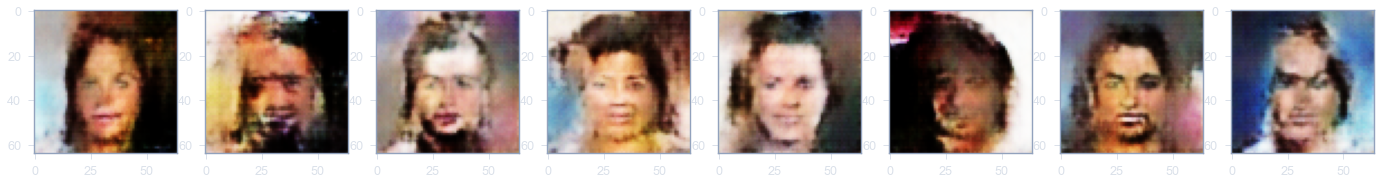

epoch 1 | 4000 | netD -0.54912 | netG 0.28118 | D_real -0.25198 | D_fake 0.43973:  68%|██████▊   | 8575/12662 [04:29<01:48, 37.55it/s]

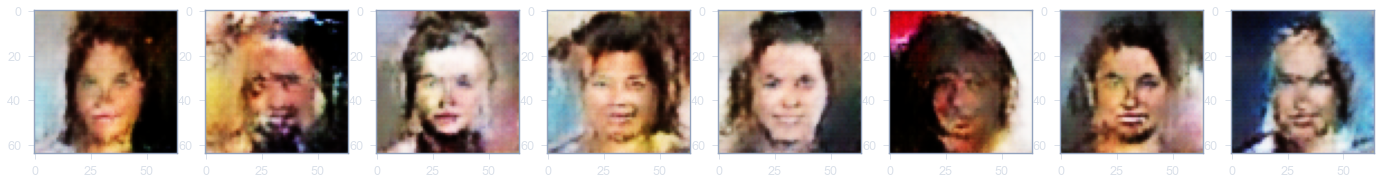

epoch 1 | 4500 | netD -0.50791 | netG 0.24070 | D_real -0.04334 | D_fake 0.52103:  88%|████████▊ | 11170/12662 [05:51<00:39, 38.07it/s]

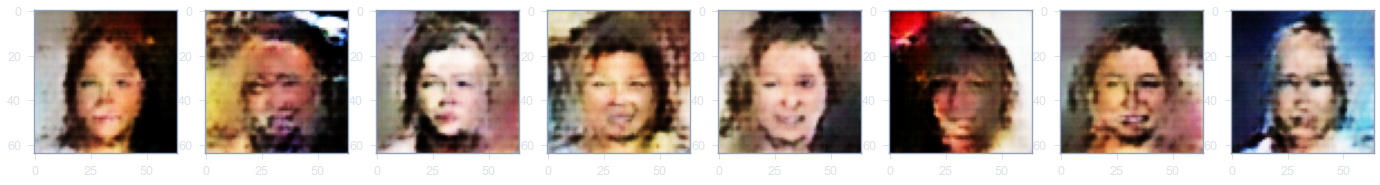

epoch 1 | 4799 | netD -0.47269 | netG 0.25646 | D_real -0.31809 | D_fake 0.20563: 100%|██████████| 12662/12662 [06:53<00:00, 33.32it/s]

In [17]:
for epoch in range(conf.epochs):
    pbar.close() # close for each run
    pbar = tqdm(total=len(loader))
    data_iter = iter(loader)
    i = 0
    while i < len(loader):
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update

        # train the discriminator Diters times
        if gen_iterations < 5 or gen_iterations % 500 == 0:
            Diters = 100
        else:
            Diters = 5
        j = 0
        while j < Diters and i < len(loader):
            j += 1

            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(-0.01, 0.01)

            x_real = data_iter.next()[0].to(device)
            i += 1
            pbar.update(1)

            netD.zero_grad()
            score, errD_real = netD(x_real)

            # noise that we will feed into netG
            noise = torch.randn(conf.batch_size, 100, 1, 1).to(device)
            with torch.no_grad():
                x_fake = netG(noise)
            score, errD_fake = netD(x_fake)

            # Earth Mover loss to udpate netD
            errD = errD_real - errD_fake
            errD.backward()
            optimizerD.step()
        loss_D_smooth = 0.9*loss_D_smooth + 0.1*errD.item()
        loss_D.append(loss_D_smooth)
        
        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        
        netG.zero_grad()
        noise = torch.randn(conf.batch_size, 100, 1, 1).to(device)
        x_fake = netG(noise)

        # update netG
        score, errG = netD(x_fake)
        errG.backward()
        optimizerG.step()
        loss_G_smooth = 0.9*loss_G_smooth + 0.1*errG.item()
        loss_G.append(loss_G_smooth)
        
        pbar.set_description(f"epoch {epoch} | {gen_iterations} | netD {loss_D_smooth:.5f} | netG {loss_G_smooth:.5f} | D_real {errD_real.item():.5f} | D_fake {errD_fake.item():.5f}")
        if gen_iterations % 500 == 0:
            with torch.no_grad():
                x_fake = netG(fixed_noise)
            show_progress(x_fake, gen_iterations)

        gen_iterations += 1



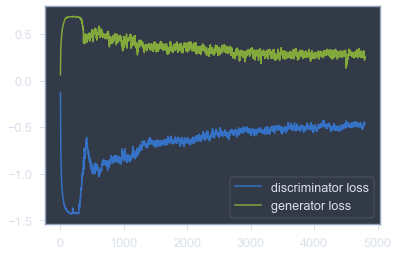

In [18]:
plt.figure()
plt.plot(range(len(loss_D)), loss_D)
plt.plot(range(len(loss_G)), loss_G)
plt.legend(['discriminator loss', 'generator loss'])
plt.show()